In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
P_avg_T = []
tau_values_T = []
P_avg_T_e = []

P_avg_inhib = []
P_avg_inhib_e = []
tau_values_inhib = []

In [2]:
def infec(N, active, dead, V, M, eta, r_in, inhib, T_LI, T_LO, LI, LO):
    t_LI = []
    t_LO = []

    #Infection rates
    r_out = eta * M/V
    N = np.count_nonzero(~dead)
    A = np.count_nonzero(active)
    
    #Initial conditions
    time = 0
    t = [time]
    Bacteria = []
    Phage_con = []
    m = []
    m_var = []

    while(np.any(~dead) and t[-1] <= 100):
        #Draw random numbers and collect transition time
        W = r_in * A + r_out * N
        x1, x2 = [np.random.uniform(0,1), np.random.uniform(0,1)]
        tau = -1/W * np.log(x1)

        if N * r_out >= x2 * W: #LO progress
            indices = np.where(~dead)[0]
            Bac = np.random.choice(indices)
            active[Bac] = True
            LO[Bac] += 1
            LI[Bac] = max(0, LI[Bac] - inhib)
            M -= 1

            if LO[Bac] >= T_LO: #LO occurs
                active[Bac] = False
                dead[Bac] = True
                M += 100
                t_LO.append(time + tau)
            
            r_out = eta * M/V
        
        else: #LI progress
            indices = np.where(active & ~dead)[0]
            Bac = np.random.choice(indices)

            LI[Bac] += 1

            if LI[Bac] >= T_LI: #LI occurs
                active[Bac] = False
                dead[Bac] = True
                M += 100
                r_out = eta * M/V
                t_LI.append(time + tau)
            

        N = np.count_nonzero(~dead)
        A = np.count_nonzero(active)

        time += tau
        indices = np.where(~dead)[0]
        m.append(np.average(LI[indices]))
        m_var.append(np.std(LI[indices]))
        Bacteria.append(A/V)
        Phage_con.append(M/V)
        t.append(time)



    return Bacteria, Phage_con, t, t_LI, t_LO, m, m_var, active, dead, N, LI, LO, t_LI, t_LO


In [3]:
#Initial conditions
N = 10**4
active = np.zeros(N, dtype = bool)
dead = np.zeros(N, dtype = bool)
V = 0.01
M = 2.6 * 10**6
eta = 2 * 10**(-9)
T_LO = 10000
inhib = 250/27 * 5
tau_d = 5
rate_in = inhib/tau_d
T_LI = rate_in * 27

LI = np.zeros(N)
LO = np.zeros(N)
t_LI = np.zeros(N)
t_LO = np.zeros(N)

par = [N, active, dead, V, M, eta, rate_in, inhib, T_LI, T_LO, LI, LO]

In [15]:
B, P, t, t_LI, t_LO, m, m_var, active, dead, N, LI, LO, t_LI, t_LO = infec(*par)
par = [N, active, dead, V, P[-1]*V, eta, rate_in, inhib, T_LI, T_LO, LI, LO]

In [ ]:
indices = np.unique(np.concatenate([[0], np.arange(0, len(P), 1000),[len(P) - 2], [len(P) - 1]]))
plt.figure(figsize = (20,6))
plt.yscale('log')
plt.grid()
plt.title('')
plt.ylabel('Bacteria and Phage concentration [1/ml]')
plt.xlabel('Time [min]')
plt.plot(np.array(t)[indices], np.array(B)[indices], label = 'Bacteria', color = 'blue')
plt.plot(np.array(t)[indices], np.array(P)[indices], label = 'Phage', color = 'orange')
plt.hist(t_LO, bins = 25, alpha = 0.5, color = 'green', label = 'Lyses from without')
plt.hist(t_LI, bins = 30, alpha = 0.5, color = 'red', label = 'Lyses from within')
plt.figure(figsize = (20,6))
plt.grid()
plt.ylabel('Phage concentration [1/ml]')
plt.xlabel('Time [min]')
plt.plot(np.array(t)[indices], np.array(P)[indices], label = 'Phage concentration', color = 'orange')
plt.figure(figsize = (20,6))
plt.grid()
plt.xlabel('Time [min]')
plt.ylabel('$m_i$')
plt.errorbar(np.array(t)[indices], np.array(m)[indices], yerr = np.array(m_var)[indices], ecolor = 'red', color = 'purple', label = 'mean value')
plt.legend()
plt.figure(figsize = (20,6))
plt.grid()
plt.xlabel('time')
plt.ylabel('m variance')
plt.plot(np.array(t)[indices], np.array(m_var)[indices], color = 'red')

In [192]:
P_avg_T.append(np.average(P))
P_avg_T_e.append(np.std(P))
tau_values_T.append(tau_d)

In [118]:
P_avg_inhib.append(np.average(P))
P_avg_inhib_e.append(np.std(P))
tau_values_inhib.append(tau_d)

(array([1676., 1259., 1031.,  760.,  568.,  433.,  284.,  210.,  129.,
          67.]),
 array([  0.        ,  24.84074074,  49.68148148,  74.52222222,
         99.36296296, 124.2037037 , 149.04444444, 173.88518519,
        198.72592593, 223.56666667, 248.40740741]),
 <BarContainer object of 10 artists>)

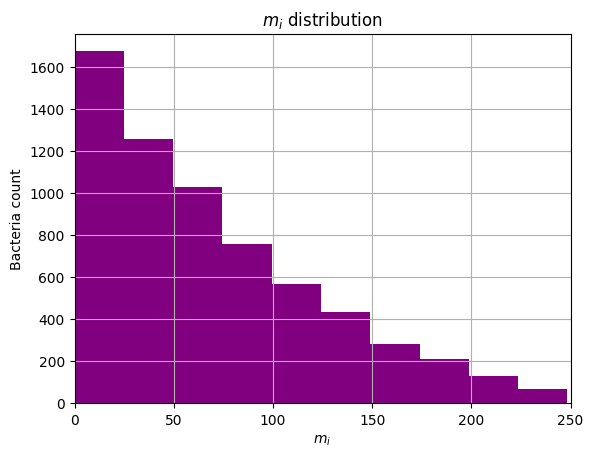

In [28]:
LI1 = LI[LI < 250]
plt.grid()
plt.title('$m_i$ distribution')
plt.xlabel('$m_i$')
plt.ylabel('Bacteria count')
plt.xlim(0,250)
plt.hist(LI1, color = 'purple')

In [224]:
par, cov = curve_fit(lin, np.array(tau_values_inhib), np.array(P_avg_inhib) / (1/(2 * 10**(-9) * np.array(tau_values_inhib))))

x = np.linspace(0, 35, 1000)

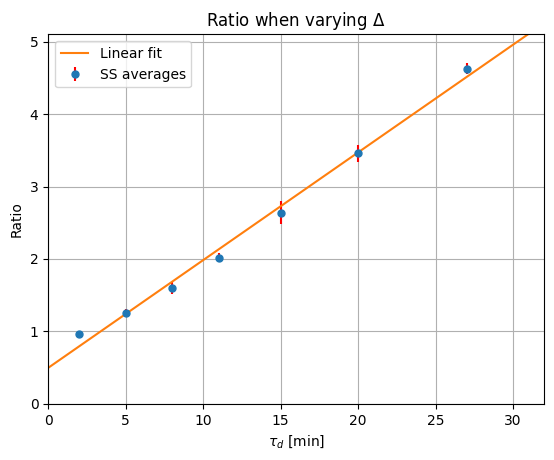

In [225]:
plt.grid()
plt.errorbar(np.array(tau_values_inhib), np.array(P_avg_inhib) / (1/(2 * 10**(-9) * np.array(tau_values_inhib))), yerr = 20*np.array(P_avg_inhib_e)/ (1/(2 * 10**(-9) * np.array(tau_values_inhib))), fmt='o', ecolor = 'red', label ='SS averages', markersize = 5)
plt.plot(x, lin(x, *par), label = 'Linear fit')
plt.xlabel('$\u03C4_d$ [min]')
plt.ylabel('Ratio')
plt.ylim(0, 5.1)
plt.xlim(0, 32)
plt.title('Ratio when varying $\Delta$')
plt.legend()

In [120]:
print(P_avg_inhib)
print(P_avg_inhib_e)
print(tau_values_inhib)

[np.float64(240443461.21946037), np.float64(126098125.42248379), np.float64(100023779.35490084), np.float64(91751017.66095556), np.float64(88009002.71464242), np.float64(86400614.07479341), np.float64(85688225.29881208)]
[np.float64(95053.59523839362), np.float64(214174.42872929526), np.float64(274722.0317252126), np.float64(133439.92470577225), np.float64(268895.3810751022), np.float64(150831.406631158), np.float64(72058.63329415383)]
[2, 5, 8, 11, 15, 20, 27]


In [226]:
def lin(x, a, b):
    y = a*x + b
    return y

par, cov = curve_fit(lin, np.array(tau_values_T), np.array(P_avg_T) / (1/(2 * 10**(-9) * np.array(tau_values_T))))

x = np.linspace(0, 35, 1000)


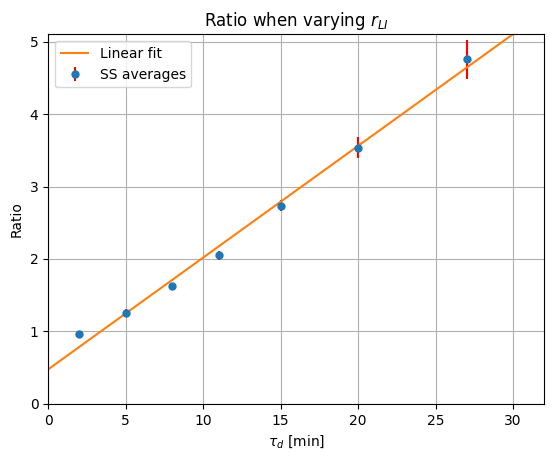

In [227]:
plt.grid()
plt.errorbar(np.array(tau_values_T), np.array(P_avg_T) / (1/(2 * 10**(-9) * np.array(tau_values_T))), yerr = 20*np.array(P_avg_T_e)/ (1/(2 * 10**(-9) * np.array(tau_values_T))), fmt='o', ecolor = 'red', label ='SS averages', markersize = 5)
plt.plot(x, lin(x, *par), label = 'Linear fit')
plt.ylim(0, 5.1)
plt.xlim(0, 32)
plt.xlabel('$\u03C4_d$ [min]')
plt.ylabel('Ratio')
plt.title('Ratio when varying $r_{LI}$')
plt.legend()

In [194]:
print(P_avg_T)
print(P_avg_T_e)
print(tau_values_T)

[np.float64(239593523.04396003), np.float64(125517240.40642418), np.float64(101412814.84081434), np.float64(93210788.65189226), np.float64(91137622.73135705), np.float64(88385632.41540977), np.float64(88021812.73600316)]
[np.float64(550706.6838291258), np.float64(256671.41220845276), np.float64(149221.2250755309), np.float64(140109.0287495342), np.float64(127308.01381730218), np.float64(184443.95070436707), np.float64(243566.4081375074)]
[2, 5, 8, 11, 15, 20, 27]
